In [140]:
import pandas as pd
import time
import random
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# Boosting!
import xgboost
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import skew
from collections import OrderedDict
pd.options.mode.chained_assignment = None

In [6]:
%run ../common_utils.py

In [215]:
def handout_RMSLE(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

## 1 - First test of XGBOOST: *eXtreme Gradient Boosting*
Just getting it to work. Understand the hyperparameters.

Tip from Hasse: you can use reg:squaredlogerror as objective and rsmle as eval_metric for the xgboost model

Unlike CatBoost or LGBM, XGBoost cannot handle categorical features by itself, it only accepts numerical values similar to Random Forest. Therefore one has to perform various encodings like label encoding, mean encoding or one-hot encoding before supplying categorical data to XGBoost.

The magic of XGBoost: handles nan values! As long as nan is distributed the same across both train and test: ez pz!

Good sources;
- https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
- https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase
- https://www.kaggle.com/pablocastilla/predict-house-prices-with-xgboost-regression
- https://analyticsindiamag.com/how-to-use-xgboost-to-predict-housing-prices-in-bengaluru-a-practical-guide/


In [218]:
train, test, metaData = load_all_data()

In [219]:
## Remove some of the ones correlated to themselves.
#features =           ["area_total", "area_kitchen", "area_living", "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed", # Numerical
#                    "district", "material", "parking"] 
#
#numerical_features = ["area_total", "area_kitchen", "area_living",
#                      "floor", "stories", "rooms", "bathrooms_shared", "balconies", "latitude", "longitude", "constructed"]
#
#cat_features = ["district", "material", "parking"]
#
#droptable = ['longitude', 'latitude', 'area_kitchen', 'area_living', 'floor', 'stories'] # Not dropping theta!

# ALL
features =           ["area_total", "area_kitchen", "area_living", "floor", "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed", # Numerical
                     "layout", "condition", "district", "material", "parking", "heating", #Categorical
                      "windows_court", "windows_street", "new", "elevator_without", "elevator_passenger", "elevator_service", "garbage_chute"] # Bool
                     #"street", "address"] #String

numerical_features = ["area_total", "area_kitchen", "area_living", "floor",
                      "ceiling", "stories", "rooms", "bathrooms_private", "bathrooms_shared", "balconies","loggias", "phones", "latitude", "longitude", "constructed"]

cat_features = ["layout", "condition", "district", "material", "parking", "heating"]

droptable = ['longitude', 'latitude']

In [220]:
# Remove outlayers from training data
outliers_value = 7
no_outlayers = train[(np.abs(stats.zscore(train['price'])) < outliers_value)]

# Not filling nan!
# Training and validation data preprocessing
labels = no_outlayers[features]
targets = no_outlayers['price']
# Skew normaliation
labels[numerical_features] = np.log1p(labels[numerical_features])

# Test data preprocessing
test_labels = test[features]
# Skew normaliation
test_labels[numerical_features] = np.log1p(test_labels[numerical_features])

In [221]:
# One-hot encoding categorical features.
#labels, test_labels = one_hot_encoder(labels, test_labels, cat_features, drop_old=drop_old)
#NB! pd.get_dummies() does pretty much the same job!
#https://stackoverflow.com/questions/36285155/pandas-get-dummies

labels = pd.get_dummies(labels,columns=cat_features)
test_labels = pd.get_dummies(test_labels,columns =cat_features)

In [222]:
# ADD R
labels, test_labels = polar_coordinates(labels, test_labels)
numerical_features.append("r")
# ADD rel_height
labels['rel_height'] = labels["floor"] / labels["stories"]
test_labels['rel_height'] = test_labels["floor"] / test_labels["stories"]
numerical_features.append("rel_height")

In [223]:
# Normalize
train_labels_n = labels.filter(numerical_features)
test_labels_n = test_labels.filter(numerical_features)

scaler = MinMaxScaler(feature_range=(0, 1))
train_labels_scaled = scaler.fit_transform(train_labels_n)
test_labels_scaled = scaler.transform(test_labels_n)

# Re-enter proceedure
training_norm_col = pd.DataFrame(train_labels_scaled, index=train_labels_n.index, columns=train_labels_n.columns) 
labels.update(training_norm_col)

testing_norm_col = pd.DataFrame(test_labels_scaled, index=test_labels_n.index, columns=test_labels_n.columns) 
test_labels.update(testing_norm_col)

### Looking for most relevant features

In [224]:
model = xgboost.XGBRegressor(
                 colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42
                )

In [120]:
# Convert all nan to "nan"?
features_with_nan = labels.columns[labels.isna().any()].tolist() # Same for train and test
#def ConverNaNToNAString(data, columnList):
#    for x in columnList:    
#        data[x] =str(data[x])
#
#ConverNaNToNAString(labels, features_with_nan)
#ConverNaNToNAString(test_labels, features_with_nan)

In [121]:
model.fit(labels,targets)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [122]:
#OrderedDict(sorted(model.booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

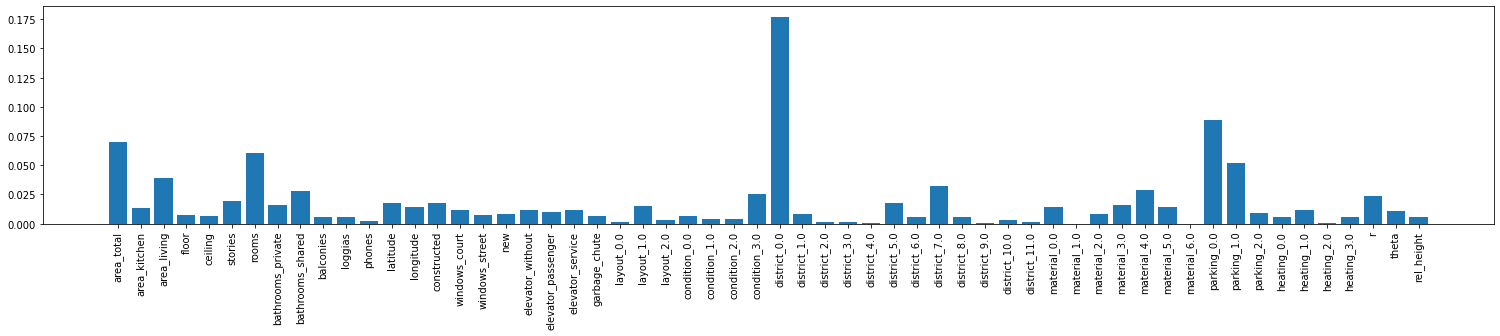

In [123]:
plt.figure(figsize=(26, 4))
plt.bar(labels.columns.tolist(), model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

### Remove less relevant features

In [124]:
# r : 0.022947283 
importance = dict(zip(labels.columns.tolist(), 
model.feature_importances_))

important_features = []
for key in importance.keys():
    if importance[key] > 0.01:
        important_features.append(key)
print(important_features)

['area_total', 'area_kitchen', 'area_living', 'stories', 'rooms', 'bathrooms_private', 'bathrooms_shared', 'latitude', 'longitude', 'constructed', 'windows_court', 'elevator_without', 'elevator_service', 'layout_1.0', 'condition_3.0', 'district_0.0', 'district_5.0', 'district_7.0', 'material_0.0', 'material_3.0', 'material_4.0', 'material_5.0', 'parking_0.0', 'parking_1.0', 'heating_1.0', 'r', 'theta']


In [126]:
labels = labels[important_features]
test_labels = test_labels[important_features]

### CUSTOM RMSLE OBJECTIVE
https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html

In [225]:
from typing import Tuple
def gradient(predt: np.ndarray, dtrain: xgboost.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    #y = dtrain.get_label()
    y = dtrain.copy()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgboost.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    #y = dtrain.get_label()
    y = dtrain.copy()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
    np.power(predt + 1, 2))

def squared_log(predt: np.ndarray, dtrain: xgboost.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Squared Log Error objective. A simplified version for RMSLE used as objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [196]:
def rmsle_metric(predt: np.ndarray, dtrain: xgboost.DMatrix) -> Tuple[str, float]:
    ''' Root mean squared log error metric.'''
    #y = dtrain.get_label()
    y = dtrain.copy()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

### Training 

In [253]:
# 
train_labels, val_labels, train_targets, val_targets = train_test_split(labels, targets, test_size=0.33, shuffle=True)

xgb_model = xgboost.XGBRegressor(eval_metric="rmsle")

smt = xgb_model.fit(train_labels, train_targets, eval_set=[(train_labels, train_targets), (val_labels, val_targets)], early_stopping_rounds=10, verbose=False)

In [254]:
xgb_prediction = xgb_model.predict(val_labels)
xgb_rmsle = handout_RMSLE(val_targets, xgb_prediction)
print('XGBoost RMSLE:', xgb_rmsle)

XGBoost RMSLE: 0.18702611509417402


In [255]:
results = xgb_model.evals_result()

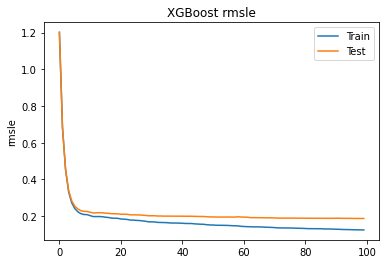

In [259]:
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)
# plot rmsle
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax.legend()
plt.ylabel('rmsle')
plt.title('XGBoost rmsle')
plt.show()

In [260]:
predict_and_store(xgb_model, test_labels, test, path="boosting_predictions/xgboost_0_1")

# TODO
- Add eval sets succesfully: https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
- Stratified/grouped k-fold
- Use GridSearchCV to optimize parameters...
- Also! Hasse got better score when just using numerical data instead of one-hot! Worth a shot.

In [144]:
# Get CV score, but doesnt fit...
kfold = StratifiedKFold(n_splits=10)
results = cross_val_score(xgb_model, train_labels, train_targets, cv=kfold)
results

array([0.89184131, 0.93247577, 0.8934875 , 0.92536204, 0.91249591,
       0.89587078, 0.89219108, 0.86814353, 0.89092057, 0.89964924])

In [158]:
#train_labels, val_labels, train_targets, val_targets = train_test_split(labels, targets, test_size=0.33, random_state=42)
#eval_set = [(train_labels, train_targets),(val_labels, val_targets)]
#eval_set = [(val_labels, val_targets)]
#xgb_model.fit(train_labels, train_targets,
#          verbose=0, early_stopping_rounds=10, eval_metric='rmsle', eval_set=eval_set)